In [1]:
import os
import gc
import sys
import warnings
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_names = ['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events',
           'games', 'standings', 'rosters', 'transactions']
path = "data/train_vs/"

train_dict = {}
for index in range(len(df_names)):
    train_dict[df_names[index]] = pd.read_pickle(os.path.join(path,df_names[index]) + "_train.pkl")

In [3]:
df_names = ['seasons', 'teams', 'players', 'awards']
path = "data/"

my_dict = {}
for index in range(len(df_names)):
    my_dict[df_names[index]] = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")

In [4]:
target_v = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')

In [5]:
target_dict = {id: target_v[target_v['playerId']==id].drop(
    ['index'], axis = 1) for id in target_v['playerId'].unique()}    

In [6]:
target_dict[112526].head(3)

,engagementMetricsDate,playerId,target1,target2,target3,target4,date
969,2018-01-02,112526,0.055277,5.496109,0.025839,16.176471,20180101
3556,2018-01-03,112526,0.060625,3.252914,0.030486,8.541353,20180102
5737,2018-01-04,112526,0.029341,1.648352,0.032613,10.490112,20180103


## Dictionary for playerBoxScores

In [7]:
perform_stats = pd.DataFrame()
perform_stats = train_dict['playerBoxScores'][[
    'playerId', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'date']]
perform_stats.head(3)

,playerId,gamePk,gameDate,gameTimeUTC,teamId,date
0,605131,529418,2018-03-29,2018-03-29T23:08:00Z,119,20180329
1,605480,529406,2018-03-29,2018-03-29T20:00:00Z,139,20180329
2,546318,529416,2018-03-29,2018-03-29T20:10:00Z,143,20180329


In [8]:
warnings.simplefilter("ignore")

In [9]:
performance = train_dict['playerBoxScores']

# Defense
perform_stats['FPCT'] = (performance['putOuts']+performance['assists']) / performance['chances']
perform_stats['Out'] = performance['putOuts'] + performance['groundOuts'] + performance['strikeOuts'] + performance['flyOuts']

# Offence
perform_stats['AB'] = performance['atBats']
perform_stats['B2'] = performance['doubles']
perform_stats['B3'] = performance['triples']
perform_stats['SB'] = performance['stolenBases']
perform_stats['CS'] = performance['caughtStealing']
perform_stats['H'] = performance['hits']
perform_stats['HR'] = performance['homeRuns']
perform_stats['IBB'] = performance['intentionalWalks']
perform_stats['HBP'] = performance['hitByPitch']
perform_stats['LOB'] = performance['leftOnBase']
perform_stats['PA'] = performance['plateAppearances']
perform_stats['TB'] = performance['totalBases']
perform_stats['GIDP'] = performance['groundIntoDoublePlay']
perform_stats['RBI'] = performance['rbi']
perform_stats['BB'] = performance['baseOnBalls']
perform_stats['SO'] = performance['strikeOuts']
perform_stats['AVG'] = perform_stats['H']/perform_stats['AB']


# Pitching
perform_stats['SV_percnt'] = performance['saves']/performance['saveOpportunities']
perform_stats['HLD'] = performance['holds']
perform_stats['BS'] = performance['blownSaves']
perform_stats['IR'] = performance['inheritedRunners']
perform_stats['IP'] = performance['inningsPitched']
perform_stats['ERA'] = (9*performance['earnedRuns'])/perform_stats['IP']
perform_stats['WHIP'] = (perform_stats['BB'] + perform_stats['H'])/perform_stats['IP']

# Advanced Offence
perform_stats['ISO'] = (perform_stats['B2']+2*perform_stats['B3']+3*perform_stats['HR'])/perform_stats['AB']
perform_stats['BABIP'] = (perform_stats['H'] - perform_stats['HR'])/(
    perform_stats['AB']-perform_stats['SO']-perform_stats['HR']+performance['sacFlies'])
perform_stats['RC'] = perform_stats['TB']*(perform_stats['H']+perform_stats['BB'])/(
    perform_stats['AB']+perform_stats['BB'])

perform_stats['PA/SO'] = perform_stats['PA']/perform_stats['SO']
perform_stats['K/BB'] = perform_stats['SO']/perform_stats['BB']

perform_stats['GS'] = 40+6*perform_stats['Out']+perform_stats['SO']-2*performance['baseOnBallsPitching']-2*performance['hitsPitching']-3*performance['runsPitching']-6*performance['homeRunsPitching']

In [10]:
select_perform = perform_stats[['playerId', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'date', 'CS', 'IBB',
                                'HBP','LOB', 'PA', 'TB', 'GIDP', 'RBI', 'BB', 'SO', 'AVG', 'SV_percnt', 'HLD','BS', 'IR', 
                                'IP', 'ERA', 'WHIP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB', 'GS']]

In [11]:
playerBS_dict = {id: select_perform[select_perform['playerId']==id] for id in target_v['playerId'].unique()}    

In [12]:
merge_1  = {}
for key, df in target_dict.items():
    df = target_dict[key].merge(playerBS_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_1[key] = df

In [13]:
train_dict.keys()

dict_keys(['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events', 'games', 'standings', 'rosters', 'transactions'])

In [14]:
# train_dict['teamBoxScores'].columns

In [15]:
select_awards = train_dict['awards'][['playerId', 'date', 'awardId']]

In [16]:
awards_dict = {id: select_awards[select_awards[
    'playerId']==id] for id in target_v['playerId'].unique()}    

In [17]:
merge_2  = {}
for key, df in target_dict.items():
    df = merge_1[key].merge(awards_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_2[key] = df

In [18]:
select_stand = train_dict['standings'][['gameDate', 'divisionId', 'teamId', 'divisionRank', 'leagueRank', 'wildCardRank', 
                                         'pct', 'homeWins', 'xWinLossPct', 'date']]

In [19]:
# train_dict['standings'].head()
merge_3  = {}
for key, df in target_dict.items():
    df = merge_2[key].merge(select_stand, on = ['date', 'teamId', 'gameDate'], how = 'left')
    merge_3[key] = df

In [20]:
select_rosters = train_dict['rosters'].drop(['status', 'index'], axis = 1)

In [21]:
rosters_dict = {id: select_rosters[select_rosters['playerId']==id] for id in target_v['playerId'].unique()}

In [22]:
merge_4  = {}
for key, df in target_dict.items():
    df = merge_3[key].merge(rosters_dict[key], on = ['date', 'playerId', 'teamId', 'gameDate'], how = 'left')
    merge_4[key] = df

In [23]:
select_games = train_dict['games'][['gamePk', 'gameType', 'gameTimeUTC', 'codedGameState', 'gameNumber',
                                   'homeId', 'homeWinPct', 'homeScore',]]

In [24]:
merge_5  = {}
for key, df in target_dict.items():
    df = merge_4[key].merge(select_games, on = ['gameTimeUTC', 'gamePk'], how = 'left')
    merge_5[key] = df

In [25]:
team_stats = pd.DataFrame()
performance_team = train_dict['teamBoxScores']
team_stats['Out_team'] = performance_team['groundOuts'] + performance_team['strikeOuts'] + performance_team['flyOuts']

# Offence
team_stats['AB_team'] = performance_team['atBats']
team_stats['B2_team'] = performance_team['doubles']
team_stats['B3_team'] = performance_team['triples']
team_stats['SB_team'] = performance_team['stolenBases']
team_stats['CS_team'] = performance_team['caughtStealing']
team_stats['H_team'] = performance_team['hits']
team_stats['HR_team'] = performance_team['homeRuns']
team_stats['IBB_team'] = performance_team['intentionalWalks']
team_stats['HBP_team'] = performance_team['hitByPitch']
team_stats['LOB_team'] = performance_team['leftOnBase']
team_stats['PA_team'] = performance_team['plateAppearances']
team_stats['TB_team'] = performance_team['totalBases']
team_stats['GIDP_team'] = performance_team['groundIntoDoublePlay']
team_stats['RBI_team'] = performance_team['rbi']
team_stats['BB_team'] = performance_team['baseOnBalls']
team_stats['SO_team'] = performance_team['strikeOuts']
team_stats['AVG_team'] = team_stats['H_team']/team_stats['AB_team']


# Pitching
team_stats['IR_team'] = performance_team['inheritedRunners']
team_stats['IP_team'] = performance_team['inningsPitched']
team_stats['ERA_team'] = (9*performance_team['earnedRuns'])/team_stats['IP_team']
team_stats['WHIP_team'] = (team_stats['BB_team'] + team_stats['H_team'])/team_stats['IP_team']

# Advanced Offence
team_stats['ISO_team'] = (team_stats['B2_team']+2*team_stats['B3_team']+3*team_stats['HR_team'])/team_stats['AB_team']
team_stats['BABIP_team'] = (team_stats['H_team'] - team_stats['HR_team'])/(
    team_stats['AB_team']-team_stats['SO_team']-team_stats['HR_team']+performance_team['sacFlies'])
team_stats['RC_team'] = team_stats['TB_team']*(team_stats['H_team']+team_stats['BB_team'])/(
    team_stats['AB_team']+team_stats['BB_team'])

team_stats['PA/SO_team'] = team_stats['PA_team']/team_stats['SO_team']
team_stats['K/BB_team'] = team_stats['SO_team']/team_stats['BB_team']

In [26]:
team_stats['Pytha_WR'] = train_dict['teamBoxScores']['runsScored']**2/(
    train_dict['teamBoxScores']['runsScored']**2 + train_dict['teamBoxScores']['runsPitching']**2)

In [27]:
team_stats.replace(np.inf, 0, inplace=True)

In [28]:
team_stats[['teamId', 'gamePk', 'gameDate', 'gameTimeUTC', 'date']] = train_dict['teamBoxScores'][[
    'teamId', 'gamePk', 'gameDate', 'gameTimeUTC', 'date']]

In [29]:
select_teamstat = team_stats[['IBB_team', 'HBP_team', 'LOB_team', 'PA_team',
       'TB_team', 'GIDP_team', 'RBI_team', 'AVG_team',
       'IR_team', 'IP_team', 'ERA_team', 'ISO_team', 'BABIP_team', 'RC_team',
       'PA/SO_team', 'K/BB_team', 'Pytha_WR', 'teamId', 'gamePk', 'gameDate',
       'gameTimeUTC', 'date']]

In [30]:
merge_6  = {}
for key, df in target_dict.items():
    df = merge_5[key].merge(select_teamstat, on = ['gamePk', 'gameDate', 'gameTimeUTC','teamId', 'date'], how = 'left')
    merge_6[key] = df

In [31]:
select_playtwt = train_dict['playerTwitterFollowers'][['date', 'playerId', 'numberOfFollowers']]
playtwt_dict = {id: select_playtwt[select_playtwt['playerId']==id] for id in target_v['playerId'].unique()}    

merge_7  = {}
for key, df in target_dict.items():
    df = merge_6[key].merge(playtwt_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_7[key] = df

In [32]:
select_playtwt = train_dict['teamTwitterFollowers'][['date', 'teamId', 'numberOfFollowers']]

merge_8  = {}
for key, df in target_dict.items():
    df = merge_7[key].merge(select_playtwt, on = ['date', 'teamId'], how = 'left')
    merge_8[key] = df

In [33]:
# train_dict['events'].columns

In [34]:
# select_events = train_dict['events'][['gamePk', 'gameDate', 'gameTimeUTC','gameType', 'eventId', 
#                                       'inning', 'halfInning', 'homeScore', 'pitcherTeamId', 
#                                      'hitterTeamId', 'pitchType', 'pitchType', 'date']]

In [35]:
# merge_6  = {}
# for key, df in target_dict.items():
#     df = merge_5[key].merge(select_events, on = ['gamePk', 'gameDate', 'gameTimeUTC','gameType'], how = 'left')
#     merge_6[key] = df

## Construct whole df

In [36]:
df = pd.concat(merge_6.values() ,axis=0)
df = df.drop(['gamePk', 'gameDate', 'gameTimeUTC', 'engagementMetricsDate'], axis = 1)
df['pct'] = df['pct'].astype('float')

In [37]:
object_encode = df.select_dtypes(include=['object'])

def label_encode(df, column):
    func = {c: i for i, c in enumerate(df[column].unique()) if not pd.isna(c)}
    df[column] = df[column].map(func)

for col in object_encode.columns:
    label_encode(object_encode, col)
df[object_encode.columns] = object_encode

In [38]:
df.replace(np.inf, 0, inplace=True)

# df = df.drop(['teamId'], axis = 1)
df = df.fillna(-99)
# df = df[df.columns.difference(['engagementMetricsDate'])].astype('float32')

In [39]:
df.head()

,playerId,target1,target2,target3,target4,date,teamId,CS,IBB,HBP,...,AVG_team,IR_team,IP_team,ERA_team,ISO_team,BABIP_team,RC_team,PA/SO_team,K/BB_team,Pytha_WR
0,628317,0.011167,4.474708,0.005168,5.735294,20180101,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,628317,0.006356,2.521008,0.001648,2.766917,20180102,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,628317,0.003556,2.380952,0.003624,3.439381,20180103,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,628317,0.003363,3.332367,0.012294,4.849601,20180104,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,628317,0.023976,1.440761,0.001501,2.371288,20180105,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


## RandomForest Model

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
X_pre = df[df.columns.difference(['target1', 'target2', 'target3', 'target4', 'date'])]
y = df[['playerId','target1', 'target2', 'target3', 'target4']]

X_dict = {id: X_pre[X_pre['playerId']==id] for id in target_v['playerId'].unique()} 

In [83]:
y['target1']

0        0.011167
1        0.006356
2        0.003556
3        0.003363
4        0.023976
          ...    
1221    16.920553
1222     1.779862
1223    12.440696
1224    10.765473
1225     7.448023
Name: target1, Length: 2508435, dtype: float64

In [42]:
regr = RandomForestRegressor(
    max_depth=20, 
    max_features = 'sqrt', 
    min_samples_split = 6, 
    n_estimators = 200, 
    random_state=0)

In [43]:
%%time
fit_4 = regr.fit(X_pre.drop(['playerId'], axis = 1),y['target4'])

Wall time: 3min 44s


In [44]:
filename = 'rf_models/esti_200/'+'model_y4_new.sav'
pickle.dump(fit_4, open(filename, 'wb'))

In [45]:
%%time
fit_3 = regr.fit(X_pre.drop(['playerId'], axis = 1),y['target3'])
filename = 'rf_models/esti_200/'+'model_y3_new.sav'
pickle.dump(fit_3, open(filename, 'wb'))

Wall time: 3min 33s


In [46]:
%%time
fit_2 = regr.fit(X_pre.drop(['playerId'], axis = 1),y['target2'])
filename = 'rf_models/esti_200/'+'model_y2_new.sav'
pickle.dump(fit_2, open(filename, 'wb'))

Wall time: 4min 6s


In [47]:
%%time
fit_1 = regr.fit(X_pre.drop(['playerId'], axis = 1),y['target1'])
filename = 'rf_models/esti_200/'+'model_y1_new.sav'
pickle.dump(fit_1, open(filename, 'wb'))

Wall time: 3min 45s


In [48]:
features = pd.DataFrame(index = X_pre.drop(['playerId'], axis = 1).columns)
for i in range(1,5):
    print(i)
    filename = 'rf_models/esti_200/'+'model_y'+str(i)+'_new.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    col_name = 'y'+str(i)
    features[col_name] = loaded_model.feature_importances_

1
2
3
4


In [49]:
stand_features = ['divisionRank', 'leagueRank', 'wildCardRank', 'pct', 'xWinLossPct']
games_features = ['gameType','codedGameState', 'gameNumber', 'homeId', 'homeWinPct', 'homeScore', 'homeWins']
team_features = ['teamId', 'IBB_team', 'HBP_team', 'LOB_team', 'PA_team', 'TB_team', 'GIDP_team', 'RBI_team', 'AVG_team','IR_team',
                  'IP_team', 'ERA_team', 'ISO_team', 'BABIP_team', 'RC_team', 'PA/SO_team', 'K/BB_team', 'Pytha_WR']
player_features = ['awardId', 'CS', 'IBB', 'HBP','LOB', 'PA', 'TB', 'GIDP', 'RBI', 'BB', 'SO', 'AVG', 'SV_percnt', 'HLD','BS', 'IR',
                    'IP', 'ERA', 'WHIP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB', 'GS', 'statusCode']

In [50]:
y1_15 = features['y1'].sort_values(ascending = False)[:15]
y2_15 = features['y2'].sort_values(ascending = False)[:15]
y3_15 = features['y3'].sort_values(ascending = False)[:15]
y4_15 = features['y4'].sort_values(ascending = False)[:15]

In [51]:
colors1 = []
for value in y1_15.index:
    if value in stand_features:
        colors1.append('r')
    elif value in games_features:
        colors1.append('b')
    elif value in team_features:
        colors1.append('g')
    elif value in player_features:
        colors1.append('y')

colors2 = []
for value in y2_15.index:
    if value in stand_features:
        colors2.append('r')
    elif value in games_features:
        colors2.append('b')
    elif value in team_features:
        colors2.append('g')
    elif value in player_features:
        colors2.append('y')
        
colors3 = []
for value in y3_15.index:
    if value in stand_features:
        colors3.append('r')
    elif value in games_features:
        colors3.append('b')
    elif value in team_features:
        colors3.append('g')
    elif value in player_features:
        colors3.append('y')
        
colors4 = []
for value in y4_15.index:
    if value in stand_features:
        colors4.append('r')
    elif value in games_features:
        colors4.append('b')
    elif value in team_features:
        colors4.append('g')
    elif value in player_features:
        colors4.append('y')

Text(0.5, 1.0, 'feature importance for y4')

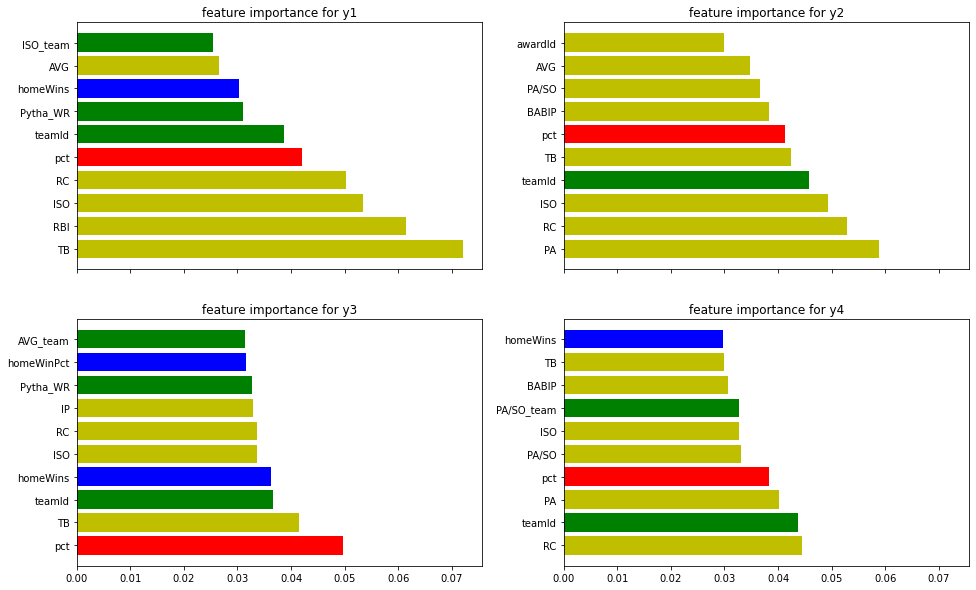

In [52]:
# plt.figure(figsize = (10,10))
fig, axs = plt.subplots(2, 2, figsize = (16,10), sharex = True)
axs[0, 0].barh(y1_15[:10].index, y1_15[:10], color=colors1)
axs[0, 0].set_title('feature importance for y1')
axs[0, 1].barh(y2_15[:10].index, y2_15[:10], color=colors2)
axs[0, 1].set_title('feature importance for y2')
axs[1, 0].barh(y3_15[:10].index, y3_15[:10], color=colors3)
axs[1, 0].set_title('feature importance for y3')
axs[1, 1].barh(y4_15[:10].index, y4_15[:10], color=colors4)
axs[1, 1].set_title('feature importance for y4')

In [53]:
y1_all = features['y1'].sort_values(ascending = True)
y2_all = features['y2'].sort_values(ascending = True)
y3_all = features['y3'].sort_values(ascending = True)
y4_all = features['y4'].sort_values(ascending = True)

fcolors1 = []
for value in y1_all.index:
    if value in stand_features:
        fcolors1.append('r')
    elif value in games_features:
        fcolors1.append('b')
    elif value in team_features:
        fcolors1.append('g')
    elif value in player_features:
        fcolors1.append('y')

fcolors2 = []
for value in y2_all.index:
    if value in stand_features:
        fcolors2.append('r')
    elif value in games_features:
        fcolors2.append('b')
    elif value in team_features:
        fcolors2.append('g')
    elif value in player_features:
        fcolors2.append('y')
        
fcolors3 = []
for value in y3_all.index:
    if value in stand_features:
        fcolors3.append('r')
    elif value in games_features:
        fcolors3.append('b')
    elif value in team_features:
        fcolors3.append('g')
    elif value in player_features:
        fcolors3.append('y')
        
fcolors4 = []
for value in y4_all.index:
    if value in stand_features:
        fcolors4.append('r')
    elif value in games_features:
        fcolors4.append('b')
    elif value in team_features:
        fcolors4.append('g')
    elif value in player_features:
        fcolors4.append('y')

Text(0.5, 1.0, 'feature importance for y4')

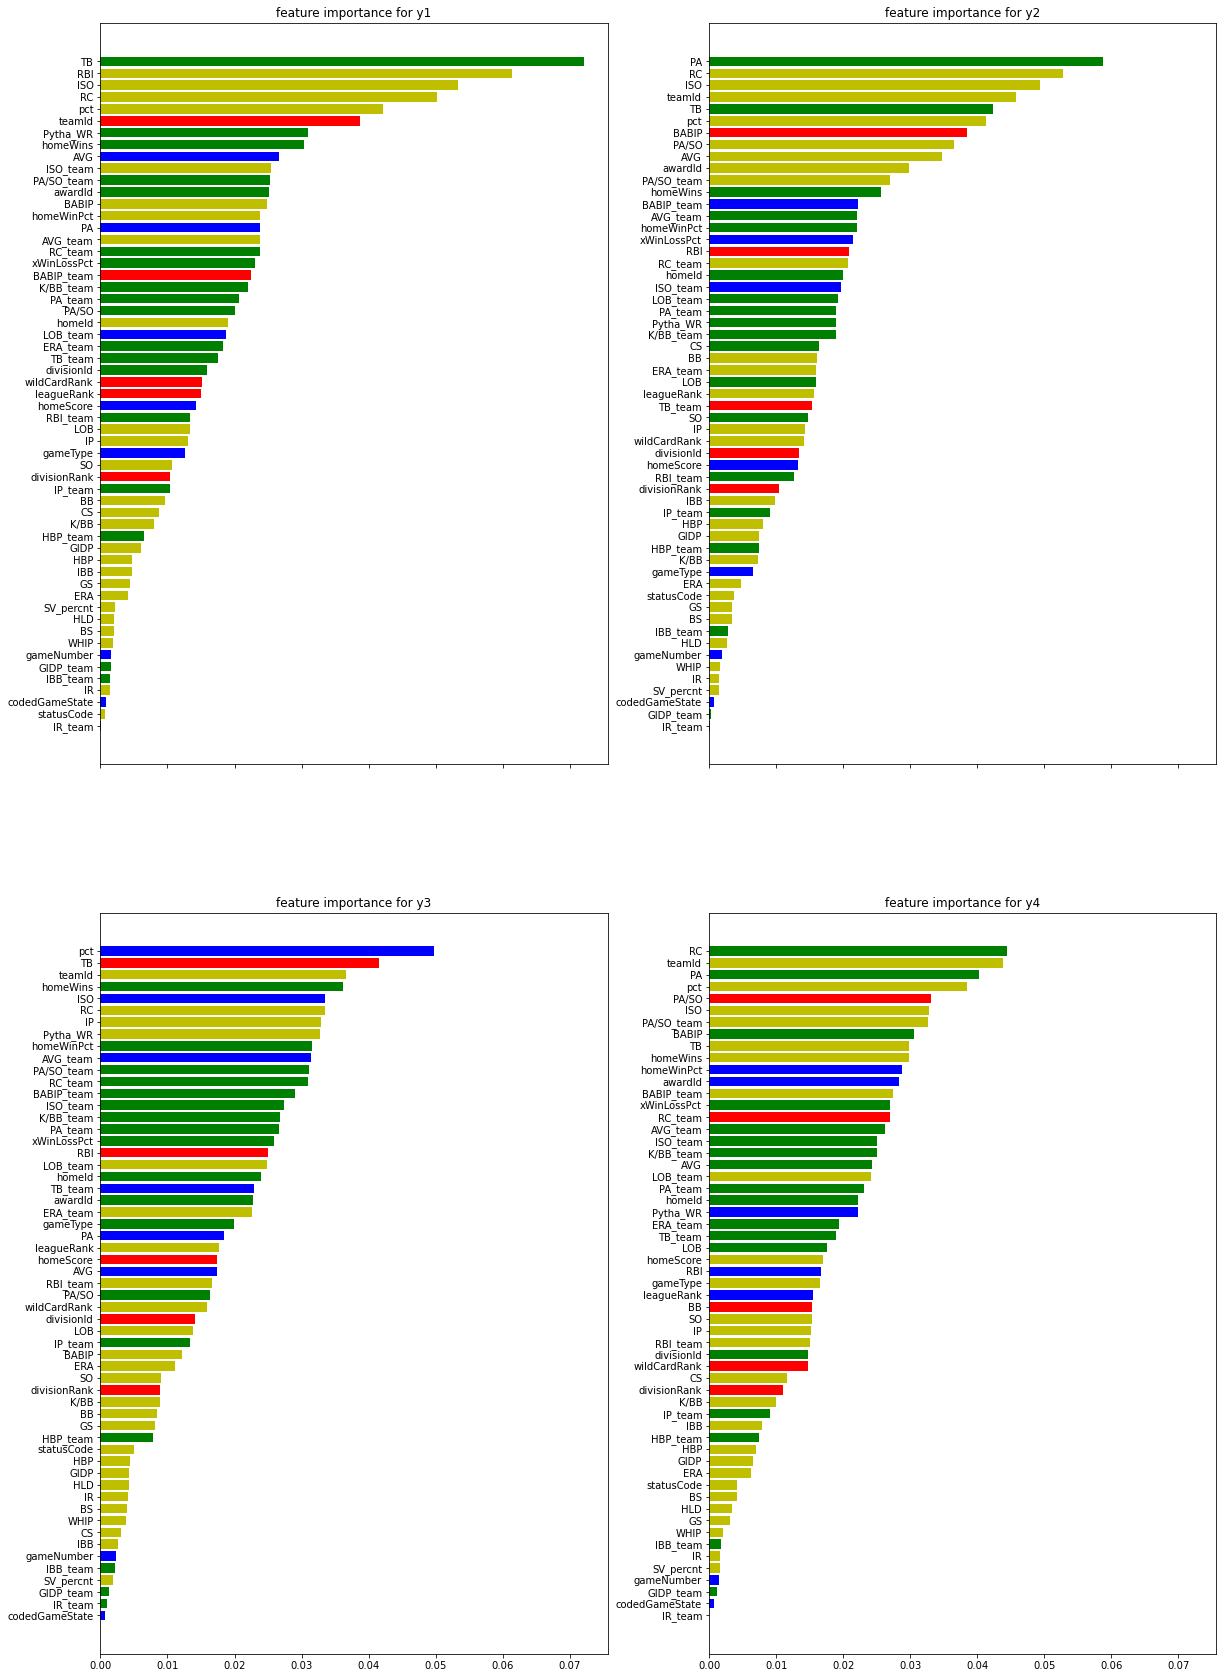

In [54]:
# plt.figure(figsize = (30,20))
fig, axs = plt.subplots(2, 2, figsize = (20,30), sharex = True)
axs[0, 0].barh(y1_all.index, y1_all, color = fcolors1)
axs[0, 0].set_title('feature importance for y1')
axs[0, 1].barh(y2_all.index, y2_all, color = fcolors2)
axs[0, 1].set_title('feature importance for y2')
axs[1, 0].barh(y3_all.index, y3_all, color = fcolors3)
axs[1, 0].set_title('feature importance for y3')
axs[1, 1].barh(y4_all.index, y4_all, color = fcolors4)
axs[1, 1].set_title('feature importance for y4')

In [55]:
stand_imp = features.T[stand_features]
games_imp = features.T[games_features]
team_imp = features.T[team_features]
player_imp = features.T[player_features]

In [56]:
grouped_feature = pd.DataFrame(columns = ['standings', 'games', 'team_perform', 'player_perform'])

In [57]:
grouped_feature['standings'] = stand_imp.mean(axis = 1)
grouped_feature['games'] = games_imp.mean(axis = 1)
grouped_feature['team_perform'] = team_imp.mean(axis = 1)
grouped_feature['player_perform'] = player_imp.mean(axis = 1)

In [58]:
grouped_feature

,standings,games,team_perform,player_perform
y1,0.021122,0.014621,0.017831,0.017509
y2,0.020632,0.012864,0.016492,0.019099
y3,0.023648,0.018883,0.021400,0.013473
y4,0.021316,0.016617,0.019403,0.015887


In [59]:
grouped_feature['target'] = grouped_feature.index

In [60]:
grouped_feature['sum'] = grouped_feature.sum(axis = 1)

In [61]:
grouped_feature['standings'], grouped_feature['games'], grouped_feature['team_perform'], grouped_feature['player_perform'] =grouped_feature['standings']/grouped_feature['sum'], grouped_feature['games']/grouped_feature['sum'], grouped_feature['team_perform']/grouped_feature['sum'], grouped_feature['player_perform']/grouped_feature['sum']

In [62]:
grouped_feature = grouped_feature.drop(['sum'], axis = 1)

<AxesSubplot:>

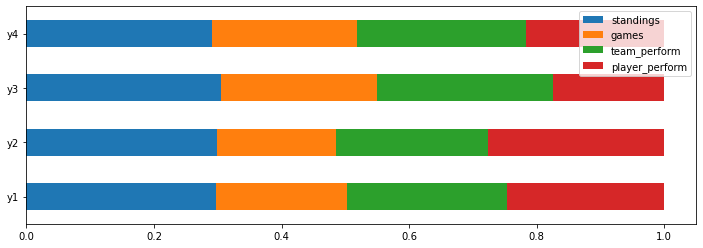

In [63]:
grouped_feature.plot(kind = 'barh', stacked = True, figsize = (12,4))

### Start feature importances plots

In [64]:
modelpath1 = 'rf_models/esti_200/y1' 
if not os.path.exists(modelpath1):
    os.makedirs(modelpath1)
    
modelpath2 = 'rf_models/esti_200/y2' 
if not os.path.exists(modelpath2):
    os.makedirs(modelpath2)
    
modelpath3 = 'rf_models/esti_200/y3' 
if not os.path.exists(modelpath3):
    os.makedirs(modelpath3)
    
modelpath4 = 'rf_models/esti_200/y4' 
if not os.path.exists(modelpath4):
    os.makedirs(modelpath4)
    
figpath = 'plots/' 
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [65]:
%%time
regr_dict_y1 = {}
feature_imp_y1 = pd.DataFrame(columns = X_dict[112526].drop(['playerId', 'awardId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav"):
        with open("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav", 'rb') as fin:
            regr_dict_y1[key] = pickle.load(fin)
            feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
    else:
        regr_dict_y1[key] = regr.fit(X_dict[key].drop(['playerId', 'awardId'], axis = 1), y[y['playerId'] == key]['target1'])
        feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
        filename = str(key)+'_model_y1.sav'
        pickle.dump(regr_dict_y1[key], open(modelpath1 +'/'+ filename, 'wb'))

Wall time: 9min 1s


In [75]:
feature_mean = pd.DataFrame()
feature_mean['y1'] = feature_imp_y1.mean(axis = 1)
feature_mean['y2'] = feature_imp_y2.mean(axis = 1)
feature_mean['y3'] = feature_imp_y3.mean(axis = 1)
feature_mean['y4'] = feature_imp_y4.mean(axis = 1)
feature_mean['mean'] = feature_mean.mean(axis = 1)

In [76]:
mean_index = feature_mean.sort_values('mean', ascending = False).index

In [77]:
mean_index

Index(['pct', 'homeWinPct', 'Pytha_WR', 'RC_team', 'TB_team', 'BABIP_team',
       'PA/SO_team', 'PA_team', 'ISO_team', 'K/BB_team', 'homeWins',
       'xWinLossPct', 'AVG_team', 'LOB_team', 'ERA_team', 'IP', 'homeId',
       'homeScore', 'leagueRank', 'RBI_team', 'TB', 'wildCardRank',
       'divisionRank', 'ISO', 'RC', 'IP_team', 'RBI', 'ERA', 'PA', 'HBP_team',
       'PA/SO', 'AVG', 'BABIP', 'gameType', 'teamId', 'LOB', 'SO', 'IR',
       'GIDP_team', 'GS', 'divisionId', 'BS', 'statusCode', 'K/BB',
       'gameNumber', 'HLD', 'codedGameState', 'IBB_team', 'SV_percnt', 'GIDP',
       'BB', 'CS', 'WHIP', 'HBP', 'IBB', 'IR_team'],
      dtype='object')

In [70]:
# plt.figure(figsize = (16,12))
# sns.heatmap(feature_imp_y1, vmax = 0.15, xticklabels=False)
# plt.savefig('plots/y1_200.jpg')

In [71]:
%%time
regr_dict_y2 = {}
feature_imp_y2 = pd.DataFrame(columns = X_dict[112526].drop(['playerId', 'awardId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav"):
        with open("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav", 'rb') as fin:
            regr_dict_y2[key] = pickle.load(fin)
            feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
    else:
        regr_dict_y2[key] = regr.fit(X_dict[key].drop(['playerId', 'awardId'], axis = 1), y[y['playerId'] == key]['target2'])
        feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
        filename = str(key)+'_model_y2.sav'
        pickle.dump(regr_dict_y2[key], open(modelpath2 +'/'+ filename, 'wb'))

Wall time: 8min 39s


In [ ]:
feature_imp_y2.shape

In [ ]:
# plt.figure(figsize = (16,12))
# sns.heatmap(feature_imp_y2, vmax = 0.15, xticklabels=False)
# # plt.savefig('plots/y2_200.jpg')

In [72]:
%%time
regr_dict_y3 = {}
feature_imp_y3 = pd.DataFrame(columns = X_dict[112526].drop(['playerId', 'awardId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav"):
        with open("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav", 'rb') as fin:
            regr_dict_y3[key] = pickle.load(fin)
            feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
    else:
        regr_dict_y3[key] = regr.fit(X_dict[key].drop(['playerId', 'awardId'], axis = 1), y[y['playerId'] == key]['target3'])
        feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
        filename = str(key)+'_model_y3.sav'
        pickle.dump(regr_dict_y3[key], open(modelpath3 +'/'+ filename, 'wb'))

Wall time: 8min 41s


In [ ]:
# plt.figure(figsize = (16,12))
# sns.heatmap(feature_imp_y3, vmax = 0.15, xticklabels=False)
# # plt.savefig('plots/y3_200.jpg')

In [73]:
%%time
regr_dict_y4 = {}
feature_imp_y4 = pd.DataFrame(columns = X_dict[112526].drop(['playerId', 'awardId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav"):
        with open("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav", 'rb') as fin:
            regr_dict_y4[key] = pickle.load(fin)
            feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
    else:
        regr_dict_y4[key] = regr.fit(X_dict[key].drop(['playerId', 'awardId'], axis = 1), y[y['playerId'] == key]['target4'])
        feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
        filename = str(key)+'_model_y4.sav'
        pickle.dump(regr_dict_y4[key], open(modelpath4 +'/'+ filename, 'wb'))

Wall time: 8min 44s


In [ ]:
# plt.figure(figsize = (16,12))
# sns.heatmap(feature_imp_y4, vmax = 0.15, xticklabels=False)
# # plt.savefig('plots/y4_200.jpg')

In [ ]:
# def zero_to_nan(values):
#     return [float('nan') if x==0 else x for x in values]

In [ ]:
# feature_imp = feature_imp_y1.copy()

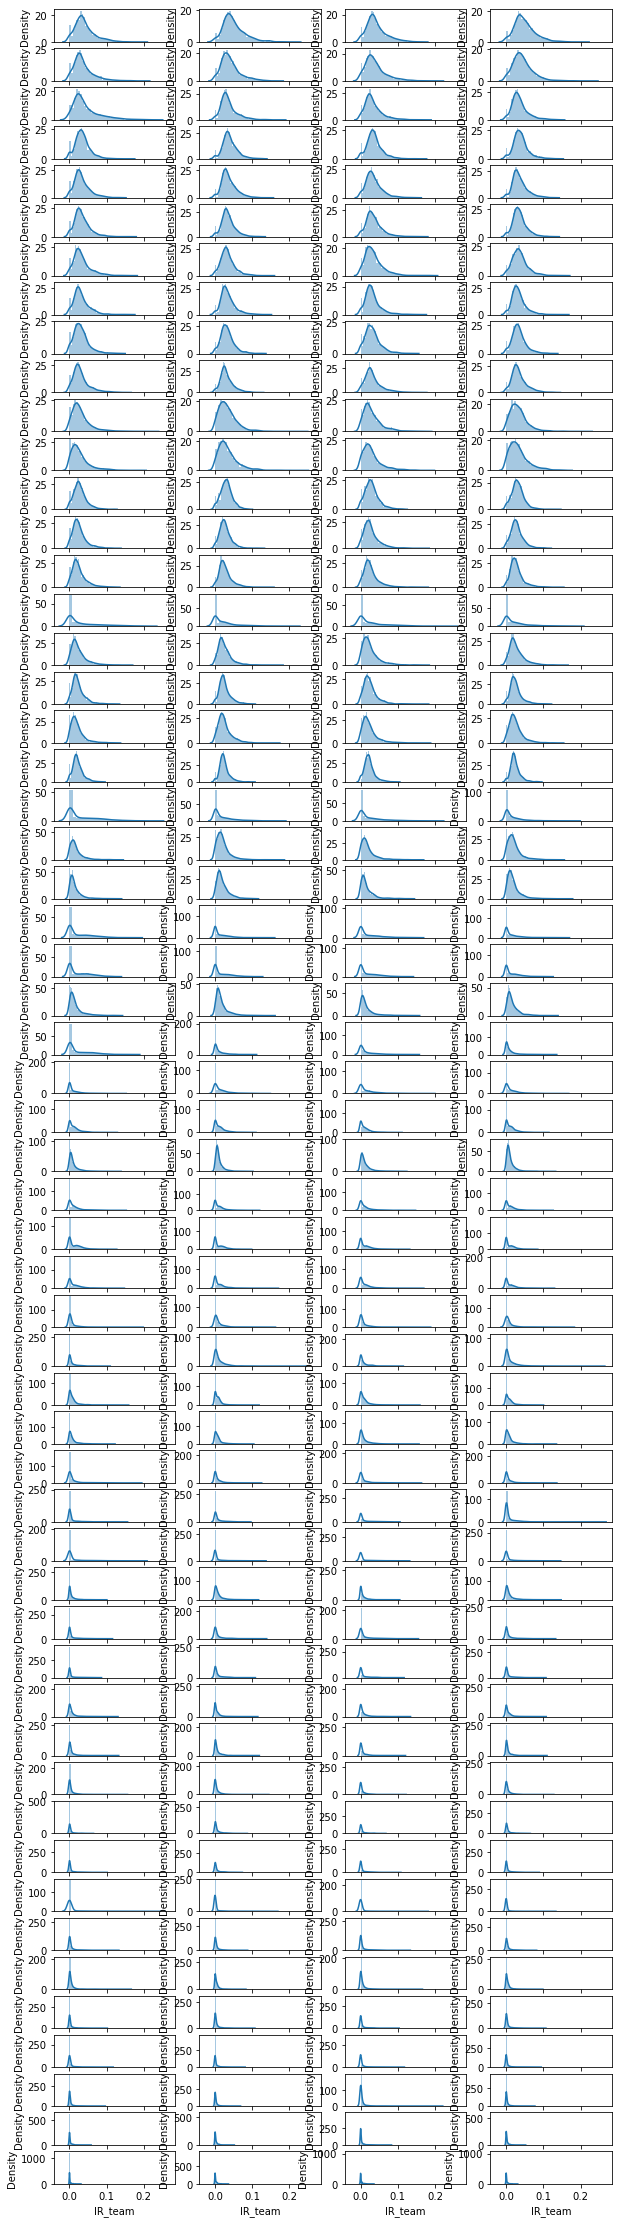

In [79]:
fig, axes = plt.subplots(mean_index.shape[0], 4, figsize=(10,40), sharex = True)
# sns.distplot(feature_imp_y1.T['homeWinPct'], ax = axes[0,0])
# sns.distplot(feature_imp_y1.T['ISO_team'], ax = axes[0,1])

for i,j in enumerate(mean_index):
    sns.distplot(feature_imp_y1.T[j], ax = axes[i,0])
    sns.distplot(feature_imp_y2.T[j], ax = axes[i,1])
    sns.distplot(feature_imp_y3.T[j], ax = axes[i,2])
    sns.distplot(feature_imp_y4.T[j], ax = axes[i,3])
plt.show()

### Add twitter columns 

In [ ]:
select_playtwt = train_dict['playerTwitterFollowers'][['date', 'playerId', 'numberOfFollowers']]
playtwt_dict = {id: select_playtwt[select_playtwt['playerId']==id] for id in target_v['playerId'].unique()}    

merge_7  = {}
for key, df in target_dict.items():
    df = merge_6[key].merge(playtwt_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_7[key] = df

In [ ]:
select_playtwt = train_dict['teamTwitterFollowers'][['date', 'teamId', 'numberOfFollowers']]

merge_8  = {}
for key, df in target_dict.items():
    df = merge_7[key].merge(select_playtwt, on = ['date', 'teamId'], how = 'left')
    merge_8[key] = df

Players who have their twitter details recorded in the dataset are taken as "major" players, are their engagement higher than other players?

In [ ]:
players_twitter = {}
players_notwit = {}
for key, item in merge_8.items():
    if merge_8[key]['numberOfFollowers_x'].fillna(-1).max()== -1:
        players_notwit[key] = merge_8[key]
    else:
        players_twitter[key] = merge_8[key]

In [ ]:
team_twitter = {}
team_notwit = {}
for key, item in merge_8.items():
    if merge_8[key]['numberOfFollowers_y'].fillna(-1).max()== -1:
        team_notwit[key] = merge_8[key]
    else:
        team_twitter[key] = merge_8[key]

In [ ]:
play_tw_y1 = pd.DataFrame()
play_tw_y2 = pd.DataFrame()
play_tw_y3 = pd.DataFrame()
play_tw_y4 = pd.DataFrame()

for key, item in players_twitter.items():
    play_tw_y1[key] = players_twitter[key]['target1']
    play_tw_y2[key] = players_twitter[key]['target2']
    play_tw_y3[key] = players_twitter[key]['target3']
    play_tw_y4[key] = players_twitter[key]['target4']

play_nt_y1 = pd.DataFrame()
play_nt_y2 = pd.DataFrame()
play_nt_y3 = pd.DataFrame()
play_nt_y4 = pd.DataFrame()

for key, item in players_notwit.items():
    play_nt_y1[key] = players_notwit[key]['target1']
    play_nt_y2[key] = players_notwit[key]['target2']
    play_nt_y3[key] = players_notwit[key]['target3']
    play_nt_y4[key] = players_notwit[key]['target4']


In [ ]:
# mean target value over players
play_tw_mean = pd.DataFrame()
play_tw_mean['y1'] = play_tw_y1.mean(axis = 1)
play_tw_mean['y2'] = play_tw_y2.mean(axis = 1)
play_tw_mean['y3'] = play_tw_y3.mean(axis = 1)
play_tw_mean['y4'] = play_tw_y4.mean(axis = 1)

play_nt_mean = pd.DataFrame()
play_nt_mean['y1'] = play_nt_y1.mean(axis = 1)
play_nt_mean['y2'] = play_nt_y2.mean(axis = 1)
play_nt_mean['y3'] = play_nt_y3.mean(axis = 1)
play_nt_mean['y4'] = play_nt_y4.mean(axis = 1)

play_tw_mean = play_tw_mean.assign(Location='has twitter')
play_nt_mean = play_nt_mean.assign(Location='no twitter')

whole_playtw = pd.concat([play_tw_mean, play_nt_mean])   

mdf_players = pd.melt(whole_playtw, id_vars=['Location'], var_name=['target'])

The plot below shows the mean target value over players who have ane do not have twitters.For all 4 target value measurements, the mean target values are higher for players who have twitter accounts. 

However, except for target 2, we can see some players who do not have twitter accounts have a higher engagement values than players who have. Therefore, target 2 may be related more to the players' popularity on internet.

In [ ]:
ax = sns.boxplot(x="target", y="value", hue="Location", data=mdf_players)    
plt.show()

In [ ]:
player_twit_y1 = feature_imp_y1[players_twitter.keys()]
player_twit_y2 = feature_imp_y2[players_twitter.keys()]
player_twit_y3 = feature_imp_y3[players_twitter.keys()]
player_twit_y4 = feature_imp_y4[players_twitter.keys()]

player_notwit_y1 = feature_imp_y1[players_notwit.keys()]
player_notwit_y2 = feature_imp_y2[players_notwit.keys()]
player_notwit_y3 = feature_imp_y3[players_notwit.keys()]
player_notwit_y4 = feature_imp_y4[players_notwit.keys()]

In [ ]:
player_twit_y1.mean(axis = 1).sort_values(ascending = False)[:11]

In [ ]:
player_twit_y2.mean(axis = 1).sort_values(ascending = False)[:11]

In [ ]:
player_twit_y3.mean(axis = 1).sort_values(ascending = False)[:11]

In [ ]:
player_twit_y4.mean(axis = 1).sort_values(ascending = False)[:11]

In [ ]:
player_notwit_y4.mean(axis = 1).sort_values(ascending = False)[:11]

In [ ]:
player_notwit_y3.mean(axis = 1).sort_values(ascending = False)[:10]

In [ ]:
player_notwit_y2.mean(axis = 1).sort_values(ascending = False)[:10]

In [ ]:
player_notwit_y1.mean(axis = 1).sort_values(ascending = False)[:10]

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(player_twit_y1, vmax = 0.15, xticklabels=False)

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(player_notwit_y1, vmax = 0.15, xticklabels=False)

In [ ]:
team_tw_y1 = pd.DataFrame()
team_tw_y2 = pd.DataFrame()
team_tw_y3 = pd.DataFrame()
team_tw_y4 = pd.DataFrame()

for key, item in team_twitter.items():
    team_tw_y1[key] = team_twitter[key]['target1']
    team_tw_y2[key] = team_twitter[key]['target2']
    team_tw_y3[key] = team_twitter[key]['target3']
    team_tw_y4[key] = team_twitter[key]['target4']

team_nt_y1 = pd.DataFrame()
team_nt_y2 = pd.DataFrame()
team_nt_y3 = pd.DataFrame()
team_nt_y4 = pd.DataFrame()

for key, item in team_notwit.items():
    team_nt_y1[key] = team_notwit[key]['target1']
    team_nt_y2[key] = team_notwit[key]['target2']
    team_nt_y3[key] = team_notwit[key]['target3']
    team_nt_y4[key] = team_notwit[key]['target4']

In [ ]:
# mean target value over players
team_tw_mean = pd.DataFrame()
team_tw_mean['y1'] = team_tw_y1.mean(axis = 1)
team_tw_mean['y2'] = team_tw_y2.mean(axis = 1)
team_tw_mean['y3'] = team_tw_y3.mean(axis = 1)
team_tw_mean['y4'] = team_tw_y4.mean(axis = 1)

team_nt_mean = pd.DataFrame()
team_nt_mean['y1'] = team_nt_y1.mean(axis = 1)
team_nt_mean['y2'] = team_nt_y2.mean(axis = 1)
team_nt_mean['y3'] = team_nt_y3.mean(axis = 1)
team_nt_mean['y4'] = team_nt_y4.mean(axis = 1)

team_tw_mean = team_tw_mean.assign(Location='has twitter')
team_nt_mean = team_nt_mean.assign(Location='no twitter')

whole_teamtw = pd.concat([team_tw_mean, team_nt_mean])   

mdf_team = pd.melt(whole_teamtw, id_vars=['Location'], var_name=['target'])

In [ ]:
ax = sns.boxplot(x="target", y="value", hue="Location", data=mdf_team)    
plt.show()

In [ ]:
# Panel Data Model

In [ ]:
df_panel = pd.concat(merge_8.values() ,axis=0)
df_panel = df_panel.drop(['gamePk', 'gameDate', 'gameTimeUTC', 'engagementMetricsDate'], axis = 1)
df_panel['pct'] = df_panel['pct'].astype('float')

In [ ]:
object_encode = df_panel.select_dtypes(include=['object'])

def label_encode(df, column):
    func = {c: i for i, c in enumerate(df[column].unique()) if not pd.isna(c)}
    df[column] = df[column].map(func)

for col in object_encode.columns:
    label_encode(object_encode, col)
df_panel[object_encode.columns] = object_encode

In [ ]:
df_panel.replace(np.inf, 0, inplace=True)
df_panel = df_panel.fillna(-99)
df_panel.head()

In [ ]:
X_panel = df_panel[df_panel.columns.difference(['target1', 'target2', 'target3', 'target4'])]
y_panel = df_panel[['playerId','target1', 'target2', 'target3', 'target4']]

X_panel_dict = {id: X_panel[X_panel['playerId']==id] for id in target_v['playerId'].unique()} 

In [ ]:
# Choose features whose importance bigger than 0.01
X_y1 = list(features['y1'][features['y1']>0.03].index) + ['playerId', 'date', 'target1']
X_y2 = list(features['y2'][features['y2']>0.03].index) + ['playerId', 'date', 'target2']
X_y3 = list(features['y3'][features['y3']>0.03].index) + ['playerId', 'date', 'target3']
X_y4 = list(features['y4'][features['y4']>0.03].index) + ['playerId', 'date', 'target4']

In [ ]:
X_t1 = df_panel[X_y1]
X_t2 = df_panel[X_y2]
X_t3 = df_panel[X_y3]
X_t4 = df_panel[X_y4]

In [ ]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm

In [ ]:
X_t1 = X_t1.set_index(['playerId', 'date'], inplace = False, append = False, drop = True)
time = X_t1.index.get_level_values('date').to_list()
X_t1['time'] = pd.Categorical(time)

In [ ]:
exog = sm.tools.tools.add_constant(X_t1)

In [ ]:
endog = X_t1['target1']

In [ ]:
endog

In [ ]:
# # random effects model
# model_re = RandomEffects(endog, exog) 
# re_res = model_re.fit() 
# # fixed effects model
# # model_fe = PanelOLS(endog, exog, entity_effects = True) 
# # fe_res = model_fe.fit() 
# #print results
# print(re_res)
# # print(fe_res)